<a href="https://colab.research.google.com/github/ekrell/icore_temp/blob/main/Easy_GPU_Acceleration_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Easy GPU Acceleration with RAPIDS

Colab offers access to NVIDIA GPU resources.

Free tier:
- [NVIDIA Tesla T4](https://www.nvidia.com/en-us/data-center/tesla-t4/)

Paid tier:
- [NVIDIA A100 Tensor Core](https://www.nvidia.com/en-us/data-center/a100/)
- [NVIDIA L4 Tensor Core](https://www.nvidia.com/en-us/data-center/l4/)

But, code has to be specially written for GPU!

GPU achieves massive speedup by exploiting the SIMD paradigm:

Arbitrary code will **not** be faster on GPU.

**Options**
- Learn to code directly for the GPU using [CUDA](https://developer.nvidia.com/cuda-zone)
- Take advantage of libraries that handle the details for you


**[RAPIDS](https://rapids.ai/ecosystem/)**

Ecosystem of high-level libraries for taking advantage of GPUs for data science applications.

This notebook is just a **very brief** intro to RAPIDS, showing how easy it is to achieve speedup with minimal change to existing code

**Activate the GPU**

Top Menu --> Runtime --> Change Runtime Type

In [ ]:
# Command to check status of GPU (running processes, load)
!nvidia-smi

# If 'command not found': check your runtime! Not connected to GPU

Fri Apr  4 19:16:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## CuDF: Accelerate Pandas

"`cudf.pandas` supports 100% of the pandas API, utilizing cuDF for supported operations and falling back to pandas when needed" - [source](https://github.com/rapidsai/cudf)

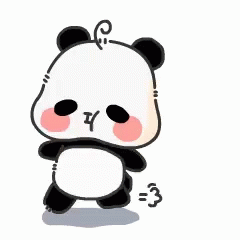

In [ ]:
# First, keep these commented to check speed withou GPU
# Then, **restart the kernel** and re-run with cudf enabled

# import cudf
# %load_ext cudf.pandas

In [ ]:
import numpy as np
import pandas as pd
import urllib

In [ ]:
def get_lagunamadre_data(years=[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]):
  selected_years = np.array(years)

  remote_directory = "https://raw.githubusercontent.com/conrad-blucher-institute/LagunaMadreWaterAirTempDataCleaner/main/imputed_data"
  file_format = "atp_and_wtp_{}.csv"

  data_files_remote = [
      remote_directory + "/" + file_format.format(str(year)) \
      for year in selected_years
  ]

  data_files = ["temperature_{}.csv".format(str(year)) for year in selected_years]

  for i in range(len(data_files)):
    urllib.request.urlretrieve(data_files_remote[i], data_files[i])

  df = pd.concat(map(pd.read_csv, data_files))

  df.rename(columns={'dateAndTime'           : 'datetime',
                    'packeryATP_lighthouse' : 'atp',
                    'npsbiWTP_lighthouse'   : 'wtp'}, inplace=True)

  df['datetime'] = pd.to_datetime(df["datetime"])
  df = df.set_index('datetime')

  return df

In [ ]:
df = get_lagunamadre_data()
df

,atp,wtp
datetime,,
2012-01-01 00:00:00,18.8,17.7
2012-01-01 01:00:00,18.9,17.6
2012-01-01 02:00:00,18.7,17.5
2012-01-01 03:00:00,19.7,17.4
2012-01-01 04:00:00,18.7,17.4
...,...,...
2022-12-31 19:00:00,19.8,16.5
2022-12-31 20:00:00,22.3,16.8
2022-12-31 21:00:00,21.4,17.4


**Who is faster? GPU or CPU?**

In [ ]:
%%timeit

df_ = df.groupby(pd.Grouper(freq='ME')).mean()

8.69 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Another example: parking violations

[Source Notebook](https://colab.research.google.com/drive/12tCzP94zFG2BRduACucn5Q_OcX1TUKY3#scrollTo=BLWa8ed6d-pD)

In [ ]:
!wget https://data.rapids.ai/datasets/nyc_parking/nyc_parking_violations_2022.parquet

# read 5 columns data:
df = pd.read_parquet(
    "nyc_parking_violations_2022.parquet",
    columns=["Registration State", "Violation Description", "Vehicle Body Type", "Issue Date", "Summons Number"]
)

# view a random sample of 10 rows:
df.sample(10)

--2025-04-04 19:16:54--  https://data.rapids.ai/datasets/nyc_parking/nyc_parking_violations_2022.parquet
Resolving data.rapids.ai (data.rapids.ai)... 3.170.229.3, 3.170.229.35, 3.170.229.120, ...
Connecting to data.rapids.ai (data.rapids.ai)|3.170.229.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 474211285 (452M) [binary/octet-stream]
Saving to: ‘nyc_parking_violations_2022.parquet’

nyc_parking_violati 100%[===================>] 452.24M  18.6MB/s    in 26s     

2025-04-04 19:17:21 (17.2 MB/s) - ‘nyc_parking_violations_2022.parquet’ saved [474211285/474211285]



,Registration State,Violation Description,Vehicle Body Type,Issue Date,Summons Number
1388162,NY,BUS LANE VIOLATION,SUBN,07/13/2021,4018131070
857865,NY,21-No Parking (street clean),4DSD,07/16/2021,8972974596
9205053,NY,40-Fire Hydrant,4DSD,02/12/2022,8857945194
8644625,FL,14-No Standing,SUBN,01/18/2022,8809144326
322455,FL,PHTO SCHOOL ZN SPEED VIOLATION,4D,07/22/2021,4741841248
2625797,NY,84-Platform lifts in low posit,VAN,07/31/2021,8953230810
6968128,NY,21-No Parking (street clean),SUBN,12/16/2021,8949173281
13435594,NJ,MOBILE BUS LANE VIOLATION,PV,05/13/2022,5601335424
6231299,NY,71-Insp. Sticker Missing (NYS,4DSD,11/02/2021,8862879805
7907943,NY,PHTO SCHOOL ZN SPEED VIOLATION,SUBN,01/03/2022,4762858857


**Race:** Which parking violation is most commonly committed by vehicles from various U.S states?

In [ ]:
%%timeit

(df[["Registration State", "Violation Description"]]  # get only these two columns
 .value_counts()  # get the count of offences per state and per type of offence
 .groupby("Registration State")  # group by state
 .head(1)  # get the first row in each group (the type of offence with the largest count)
 .sort_index()  # sort by state name
 .reset_index()
)

2.91 s ± 315 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Race:** Which vehicle body types are most frequently involved in parking violations?

In [ ]:
%%time

(df
 .groupby(["Vehicle Body Type"])
 .agg({"Summons Number": "count"})
 .rename(columns={"Summons Number": "Count"})
 .sort_values(["Count"], ascending=False)
)

CPU times: user 730 ms, sys: 200 ms, total: 930 ms
Wall time: 925 ms


,Count
Vehicle Body Type,
SUBN,6449007
4DSD,4402991
VAN,1317899
DELV,436430
PICK,429798
...,...
XRL,1
XT,1
YANT,1


**Race:** How do parking violations vary across days of the week?

In [ ]:
%%time

weekday_names = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}

df["Issue Date"] = df["Issue Date"].astype("datetime64[ms]")
df["issue_weekday"] = df["Issue Date"].dt.weekday.map(weekday_names)

df.groupby(["issue_weekday"])["Summons Number"].count().sort_values()

CPU times: user 8.34 s, sys: 443 ms, total: 8.79 s
Wall time: 8.81 s


,Summons Number
issue_weekday,
Sunday,462992
Saturday,1108385
Monday,2488563
Wednesday,2760088
Tuesday,2809949
Friday,2891679
Thursday,2913951


## CuPY: Accelerate NumPy and SciPy

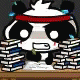

In [ ]:
import xarray as xr

import numpy as np
import cupy as cp

**Get a big data**

In [ ]:
url = "https://thredds.nci.org.au/thredds/fileServer/ra22/satellite-products/arc/obs/himawari-ahi/fldk/v1-0/2025/01/01/0000/20250101000000-P1S-ABOM_OBS_B05-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc"

In [ ]:
!wget {url}
!ls

--2025-04-04 19:17:59--  https://thredds.nci.org.au/thredds/fileServer/ra22/satellite-products/arc/obs/himawari-ahi/fldk/v1-0/2025/01/01/0000/20250101000000-P1S-ABOM_OBS_B05-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc
Resolving thredds.nci.org.au (thredds.nci.org.au)... 130.56.243.220
Connecting to thredds.nci.org.au (thredds.nci.org.au)|130.56.243.220|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 23265526 (22M) [application/x-netcdf]
Saving to: ‘20250101000000-P1S-ABOM_OBS_B05-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc’

20250101000000-P1S- 100%[===================>]  22.19M  18.3MB/s    in 1.2s    

2025-04-04 19:18:01 (18.3 MB/s) - ‘20250101000000-P1S-ABOM_OBS_B05-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc’ saved [23265526/23265526]

20250101000000-P1S-ABOM_OBS_B05-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc  temperature_2016.csv
nyc_parking_violations_2022.parquet				   temperature_2017.csv
sample_data							   temperature_2018.csv
temperature_2012.csv						   temperature_2019.csv
temperatu

In [ ]:
ds = xr.open_mfdataset("20250101000000-P1S-ABOM_OBS_B05-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc")
ds

<xarray.Dataset> Size: 121MB
Dimensions:                       (time: 1, y: 5500, x: 5500)
Coordinates:
  * time                          (time) datetime64[ns] 8B 2025-01-01
  * x                             (x) float64 44kB -5.499e+06 ... 5.499e+06
  * y                             (y) float64 44kB 5.499e+06 ... -5.499e+06
Data variables:
    channel_0005_scaled_radiance  (time, y, x) float32 121MB dask.array<chunksize=(1, 20, 5500), meta=np.ndarray>
    geostationary                 float32 4B ...
    scan_line_time                (y) datetime64[ns] 44kB dask.array<chunksize=(20,), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    acknowledgment:                  See disclaimer
    cdm_data_type:                   grid
    comment:                         AGLS observations geometry product
    contributor_name:                Commonwealth of Australia, Bureau of Met...
    ...                              ...
    time_coverage_start:             20250101T000021Z
    wmo_platform_name:               Himawari-9
    wmo_satellite_number:            174
    history:                         Fri Feb 21 00:07:52 2025: ncatted -O -a ...
    NCO:                             netCDF Operators version 4.7.7 (Homepage...
    product_version:                 1.0

In [ ]:
arr = ds["channel_0005_scaled_radiance"].values[0]
arr.shape

(5500, 5500)

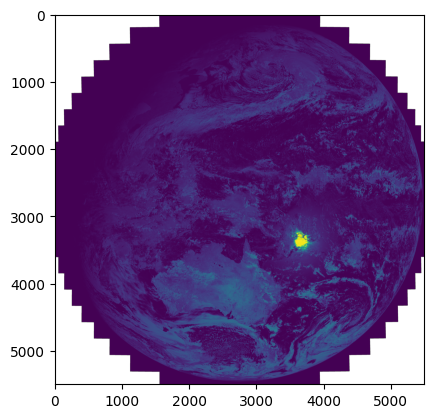

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(arr)

In [ ]:
# Make a cuPy version of the array
arr_cp = cp.array(arr)

In [ ]:
arr.nbytes / 1e9

0.121

In [ ]:
%%timeit
arr.flatten()

42.4 ms ± 631 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
arr_cp.flatten()

The slowest run took 6.11 times longer than the fastest. This could mean that an intermediate result is being cached.
36.4 µs ± 32.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
np.where(arr == 0)

144 ms ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
cp.where(arr_cp == 0)

4.18 ms ± 9.02 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
np.sqrt(arr)

<magic-timeit>:1: RuntimeWarning: invalid value encountered in sqrt


35.8 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
cp.sqrt(arr_cp)

970 µs ± 2.26 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
